# Base parameters and combinations with QR

In the following, the QR decomposition is used to find columns in a matrix (e.g. dynamics regressor) that are independent and therefore are a choice of a basis for the identifiable subspace. It is then determined which linear combinations of the other dependent columns are forming the base columns/parameters in each of those. The calculations are done in the example context of parameter identification.

In [2]:
#imports
import numpy as np; np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
import numpy.linalg as la
%matplotlib notebook
import matplotlib
#print(matplotlib.style.available)
matplotlib.style.use('classic')
import sympy
sympy.init_printing(use_latex='mathjax')
from sympy import symbols, solve, simplify, Eq, Symbol

In [12]:
# define some test matrix ('regressor')

"""
a = np.array([[1.0, 2.0,  .0,  5.0, 2.0, 3.0, 5.0],
              [1.0, 2.0,  .0,  4.0, 1.5, 2.5, 4.5],
              [ .0,  .0, 1.0,   .0,  .0,  .0, 0.0],
              [ .0,  .0, 1.0,   .0,  .0,  .0, 0.0],
              [2.0, 4.0,  .0,  6.0,  .0, 6.0, 10.0],
              [ .0,  .0, 0.5,  0.5, 0.5,  .0, 0.0]])
"""
a = np.array([[1.0, 2.0,  .0,  5.0, 2.0, 3.0],
              [1.0, 2.0,  .0,  4.0, 1.5, 2.5],
              [ .0,  .0, 1.0,   .0,  .0,  .0],
              [ .0,  .0, 1.0,   .0,  .0,  .0],
              [2.0, 4.0,  .0,  6.0,  .0, 6.0],
              [ .0,  .0, 0.5,  0.5, 0.5,  .0]])
#TODO: try with 0 columns = non-identifiable parameters

r = np.linalg.matrix_rank(a)
print("Rank:", r)

#only used for testing here, does not always work with real data matrices
rref = sympy.Matrix(a).rref()
print("Reduced row-echelon:", rref)

Rank: 4
Reduced row-echelon: (Matrix([
[1.0, 2.0,   0,   0,   0,    0],
[  0,   0, 1.0,   0,   0,    0],
[  0,   0,   0, 1.0,   0,  1.0],
[  0,   0,   0,   0, 1.0, -1.0],
[  0,   0,   0,   0,   0,    0],
[  0,   0,   0,   0,   0,    0]]), [0, 2, 3, 4])


Test Matrix $a$ is rank deficient (rank $r<m$). The rank 4 means there are 4 sets of (mutually) dependent columns, each with 1 or more columns in it. The columns $0,1$ and $4,5$ are linearly dependent (that makes 4 sets). Columns $2,3,4$ are linearly independent from all other columns. Finding independent columns should give a single representant of each set. Hence, the choice is non-unique if any set has more than one element. If a column was independent in the original matrix, there can not be other columns dependent on it and it is a single element in its set.

Assuming the set of linear equations, x being a known ("parameter") vector
$$A\cdot x = t$$

In [11]:
# define some arbitrary parameters
x_real = np.array([1.0,1.7,3.0,4.0,4.0,0.6])#,4.0])  #param
x_cad = np.array([1.0,2.1,3.0,4.3,4.0,0.4])#,4.0])
#x = x_real - x_cad   #use a priori
x = x_real
t_real = a.dot(x_real)
print("'torques'", t_real)
#t = a.dot(x)
#print(t)

'torques' [ 34.200  27.900  3.000  3.000  36.400  5.500]


## Sets of dependent columns


Find sets of columns that are linearly independent to each other. For non-pivoting QR, the columns in R with diagonal elements that are not zero are "independent", i.e. these columns are selected as representative for this set with factor 1. For pivoting QR it does not work the same way. As there are as many "independent" sets as the rank of the matrix, taking the first rank columns of the permutation also gives the independent column indices but in different order. The choices for the representatives are possibly not the same but from the same independent sets.

Assuming $m \times n$ Matrix $a$ with $m>=n$.

In [98]:
import scipy.linalg as sla
Qp,Rp,P = sla.qr(a, pivoting=True, check_finite=True)
print(Rp)
print(Rp.diagonal())
print("Permutation from QR:", P)
#create proper permutation matrix from P
Pp = np.zeros((P.size, P.size))
for i in P:
    Pp[i,P[i]]=1
Pb = Pp.T[:, 0:r]
Pd = Pp.T[:, r:]

#Qp.T.dot(a).dot(Pp.T)  #== R

#QR gets orthonormal basis directly, it is the same dimension as a however, not projecting to subspace
B_direct = Qp[:, :]
B_direct[np.abs(B_direct) < tol] = 0
S = np.zeros_like(Rp)
for i in range(Rp.shape[0]):
        if np.abs(Rp[i,i]) < tol:
            continue
        if Rp[i,i] < 0:
            S[i,i] = -1
        if Rp[i,i] > 0:
            S[i,i] = 1
#print(S)
B_direct = B_direct.dot(S)[:, :r]
print(B_direct)
print(a.dot(np.eye(B_direct.shape[0]) - B_direct.dot(B_direct.T)))

[[-8.789 -1.849 -0.028 -4.779 -6.940 -2.389]
 [ 0.000 -1.755 -0.112  1.045  1.755  0.523]
 [ 0.000  0.000 -1.496  0.012 -0.000  0.006]
 [ 0.000  0.000  0.000 -0.269 -0.000 -0.134]
 [ 0.000  0.000  0.000  0.000 -0.000 -0.000]
 [ 0.000  0.000  0.000  0.000  0.000 -0.000]]
[-8.789 -1.755 -1.496 -0.269 -0.000 -0.000]
Permutation from QR: [3 4 2 1 5 0]
[[ 0.569  0.540 -0.051 -0.574]
 [ 0.455  0.375 -0.037  0.807]
 [ 0.000  0.000  0.669  0.031]
 [ 0.000  0.000  0.669  0.031]
 [ 0.683 -0.719  0.041 -0.049]
 [ 0.057  0.225  0.316 -0.122]]
[[-0.364 -0.000 -2.864  2.136  0.182  1.455]
 [-0.299 -0.000 -2.299  1.701  0.149  1.195]
 [ 0.052  0.000  0.552 -0.448 -0.026 -0.208]
 [ 0.052  0.000  0.552 -0.448 -0.026 -0.208]
 [-0.831 -0.000 -3.831  2.169  0.416  3.325]
 [ 0.039 -0.000  0.039  0.039 -0.019 -0.156]]


In [94]:
tol = minTol = 1e-10
print("rank (QR): {}".format(np.where(np.abs(Rp.diagonal()) > tol)[0].size ))   #rank with pivoting QR
indepsQRP = P[0:r]
print("chosen set of independent columns:", indepsQRP)

rank (QR): 4
chosen set of independent columns: [3 4 2 1]


In [99]:
#Gautier 1990, 3-4: linear relationships
W1W2 = a.dot(Pp.T)
#W1 = W1W2[:,0:r]
#W2 = W1W2[:,r:]
W1 = a.dot(Pb)
W2 = a.dot(Pd)

print(W1)

#express dependent columns (in W2) as linear combinations of independent columns (in W1)
R1 = Rp[0:r,0:r]
R2 = Rp[0:r,r:]
linDeps = la.inv(R1).dot(R2)
print("linDeps:\n", linDeps, "\n")

print(W2)
print("should be equal to")
print(W1.dot(linDeps))
print(linDeps.dot(Pp.T[:, r:].T))

[[ 5.000  2.000  0.000  2.000]
 [ 4.000  1.500  0.000  2.000]
 [ 0.000  0.000  1.000  0.000]
 [ 0.000  0.000  1.000  0.000]
 [ 6.000  0.000  0.000  4.000]
 [ 0.500  0.500  0.500  0.000]]
linDeps:
 [[ 1.000 -0.000]
 [-1.000  0.000]
 [ 0.000  0.000]
 [ 0.000  0.500]] 

[[ 3.000  1.000]
 [ 2.500  1.000]
 [ 0.000  0.000]
 [ 0.000  0.000]
 [ 6.000  2.000]
 [ 0.000  0.000]]
should be equal to
[[ 3.000  1.000]
 [ 2.500  1.000]
 [ 0.000  0.000]
 [ 0.000  0.000]
 [ 6.000  2.000]
 [-0.000  0.000]]
[[-0.000  0.000  0.000  0.000  0.000  1.000]
 [ 0.000  0.000  0.000  0.000  0.000 -1.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.500  0.000  0.000  0.000  0.000  0.000]]


## Getting base params with explicit QR relationships (Gautier 1990)

$Pp^T X_B = [X_{B_1} ; X_{B_2}] = [X_1 + R_1^{-1}R_2 X_2;0]$

The base params are obtained from the standard params numerically, grouping certain columns of the initial matrix.

In [10]:
print(P)
PTx = Pp.dot(x)
print('x:\t', x)
x1 = PTx[0:r]
x2 = PTx[r:]
print ('x1, x2:\t', x1, x2)
xb1 = x1 + la.inv(R1).dot(R2).dot(x2)
print ("Base Params:", xb1)

[3 4 2 1 5 0]
x:	 [ 1.000  1.700  3.000  4.000  4.000  0.600]
x1, x2:	 [ 4.000  4.000  3.000  1.700] [ 0.600  1.000]
Base Params: [ 4.600  3.400  3.000  2.200]


###  Getting the dependencies expressed for each of the independent columns

Similar to the base param values, $R_1^{-1}R_2$ gives the linear relationship between the dependent columns in $W_2$ and the independent ones in $W_1$. The base matrix columns are the weighted sum with those coefficients.
The symbolic relationships can thus be retrieved.

In [88]:
print("P:", P)
print("x:\n", x)
print("a:\n", a)
print("linDeps:\n", linDeps)

syms = symbols('c0:%d' % a.shape[1])

'''
# collect dependencies expressed from dependent columns (coming like that from QR)
indep_eqs = list()
for j in range(0,linDeps.shape[1]):
    dep_org_col = P[indepsQRP.size+j]
    # build linear equation for this dependent column
    eq = 0
    #go through all dependencies of this col and collect all grouped params
    for i in range(0,linDeps.shape[0]):   
        if np.abs(linDeps[i,j]) > 0.01:
            indep_org_col = P[i]
            eq += round(linDeps[i,j], 4)*syms[indep_org_col]
            
    eq = Eq(syms[dep_org_col], eq)
    print("{} = {}".format(eq.lhs, eq.rhs))
    indep_eqs.append(eq)
print(indep_eqs)
'''

# collect grouped columns for each independent column ("representatives" of the groups of linear dependent columns)
base_deps = {}
B_qr = np.zeros((a.shape[1],r))
for j in range(0, linDeps.shape[0]):
    indep_idx = P[0:r][j]
    for i in range(0, linDeps.shape[1]):
        for k in range(r, P.size):
            #factor = round(linDeps[j, k-r], 4)
            factor = linDeps[j, k-r]
            if np.abs(factor)>tol: B_qr[P[k],j] = factor
    B_qr[indep_idx, j] = 1

#test orthogonality
#print(a.dot(np.eye(B_qr.shape[0]) - B_qr.dot(la.pinv(B_qr))))

print("\nB_qr:\n", B_qr)

B_qr_inv_z = la.pinv(B_qr)
B_qr_inv_z[np.abs(B_qr_inv_z) < minTol] = 0

base_deps = np.dot(syms, B_qr_inv_z.T)   #get symbolic equations from basis and corresponding symbols
print('base param eqns:', base_deps)
#a_base_qr = a[:, indepsQRP] + linDeps.dot(a[:,P[r:]].T).T
a_base_qr = a.dot(B_qr)
print("a_base:")
print(a_base_qr)

#since B_qr is not an orthogonal basis (B_qr.T != B_qr^-1), we have to use pinv instead of T
B_qr_inv = la.pinv(B_qr)
#x_base_qr = x.dot(B_qr)
x_base_qr = B_qr_inv.dot(x)
print("x_base_qr:\t", x_base_qr)
#print('back to std params:\t', x_base_qr.dot(B_qr_inv))
print('back to std params:\t', B_qr.dot(x_base_qr))
t_base = a_base_qr.dot(x_base_qr)
print('\nestimated "torques", should be equal:')
print('t:\t', t)
print('t_base:\t', t_base)

print('\northogonalised projection')
#get orthogonal basis of basis, so orthogonalize it
Q_B_qr, R_B_qr = la.qr(B_qr)
Q_B_qr[np.abs(Q_B_qr) < tol] = 0
S = np.zeros_like(R_B_qr)
for i in range(R_B_qr.shape[0]):
    for j in range(R_B_qr.shape[1]):
        if i!=j:
            continue
        if R_B_qr[i,j] < 0:
            S[i,j] = -1
        if R_B_qr[i,j] > 0:
            S[i,j] = 1
#print(S)
B_qr_orth = Q_B_qr.dot(S)
#B_qr_orth = Q_B_qr

base_deps_orth = np.dot(syms, B_qr_orth)
print("B_qr_orth:\n", B_qr_orth)
print('orth base param eqns:', base_deps_orth)
x_base_qr_orth = B_qr_orth.T.dot(x)
print("x_base_qr_orth:\t", x_base_qr_orth)
print('back to std params:\t', x_base_qr_orth.dot(B_qr_orth.T)) #
print('back to std params:\t', B_qr_orth.dot(x_base_qr_orth))

a_base_qr_orth = a.dot(B_qr_orth)
t_base = a_base_qr_orth.dot(x_base_qr_orth)
print('\nestimated "torques", should be equal:')
print('t:\t', t)
print('t_base:\t', t_base)

P: [3 4 2 1 5 0]
x:
 [ 1.000  1.700  3.000  4.000  4.000  0.600]
a:
 [[ 1.000  2.000  0.000  5.000  2.000  3.000]
 [ 1.000  2.000  0.000  4.000  1.500  2.500]
 [ 0.000  0.000  1.000  0.000  0.000  0.000]
 [ 0.000  0.000  1.000  0.000  0.000  0.000]
 [ 2.000  4.000  0.000  6.000  0.000  6.000]
 [ 0.000  0.000  0.500  0.500  0.500  0.000]]
linDeps:
 [[ 1.000 -0.000]
 [-1.000  0.000]
 [ 0.000  0.000]
 [ 0.000  0.500]]

B_qr:
 [[ 0.000  0.000  0.000  0.500]
 [ 0.000  0.000  0.000  1.000]
 [ 0.000  0.000  1.000  0.000]
 [ 1.000  0.000  0.000  0.000]
 [ 0.000  1.000  0.000  0.000]
 [ 1.000 -1.000  0.000  0.000]]
base param eqns: [0.666666666666667*c3 + 0.333333333333333*c4 + 0.333333333333333*c5
 0.333333333333333*c3 + 0.666666666666667*c4 - 0.333333333333334*c5 1.0*c2
 0.4*c0 + 0.8*c1]
a_base:
[[ 8.000 -1.000  0.000  2.500]
 [ 6.500 -1.000  0.000  2.500]
 [ 0.000  0.000  1.000  0.000]
 [ 0.000  0.000  1.000  0.000]
 [ 12.000 -6.000  0.000  5.000]
 [ 0.500  0.500  0.500  0.000]]
x_base_qr:	 

## Getting the base projection matrix from QR directly

The columns of $Q$ are orthonormal ($Q^TQ = I$) and have the same span as the columns of $A$.
For $Q,R=QR(A)$, $Q^TQ$ is thus a projection of a vector $b$ onto $\text{range}(A)$.
The first $r$ orthogonal columns of $Q$ form the basis or projection $B$ of the column space of $A_\text{base}$. (Q is orthonormal if A is square, $Q^TQ = QQ^T = I$. In the rectangular case it is only orthogonal).
$B$ can be used to project the matrix $A$ with regard to a vector $v$ to a matrix $A_\text{base}$ with regard to a vector $v_\text{base}$. It has to be noticed though that the choice of the basis is very different from the one that results from the explicit method using QR from Gautier. 

In [56]:
Qpt,Rpt,Pt = sla.qr(a.T, pivoting=True, mode='economic')  #QR gets row space basis, so have to transpose (?)
#print(Qpt)
#B = -Qpt[:, 0:r]
Qpt[np.abs(Qpt) < tol] = 0
S = np.zeros_like(Rpt)
for i in range(Rpt.shape[0]):
    for j in range(Rpt.shape[1]):
        if i!=j:
            continue
        if Rpt[i,j] < 0:
            S[i,j] = -1
        if Rpt[i,j] > 0:
            S[i,j] = 1
#print(S)
B = Qpt.dot(S)[:, :r]
print(B)

#get linear equations for base params from projection (each column is a basis vector for the subspace)
base_deps_q = {}
print("\nsymbolic relations of base params/columns:")
for j in range(0, B.shape[1]):
    eq = 0*syms[0]
    for i in range(0, B.shape[0]):
        eq += B[i, j]*syms[i]
    base_deps_q[j] = eq
print(base_deps_q)

[[ 0.209 -0.103  0.000  0.382]
 [ 0.417 -0.206  0.000  0.764]
 [ 0.000  0.000  1.000  0.000]
 [ 0.626  0.480  0.000 -0.212]
 [ 0.000  0.788  0.000  0.212]
 [ 0.626 -0.309  0.000 -0.424]]

symbolic relations of base params/columns:
{0: 0.208514414057075*c0 + 0.417028828114149*c1 + 0.625543242171224*c3 + 0.625543242171224*c5, 1: -0.102838675528659*c0 - 0.205677351057318*c1 + 0.479913819133743*c3 + 0.78842984571972*c4 - 0.308516026585977*c5, 2: 1.0*c2, 3: 0.382028723980208*c0 + 0.764057447960416*c1 - 0.212238179989004*c3 + 0.212238179989004*c4 - 0.424476359978009*c5}


In [52]:
a_base = a.dot(B)
print('a_base:\n', a_base)
x_base = B.T.dot(x)
print('x_base:\t', x_base)
t_base = a_base.dot(x_base)
print('t:\t', t)
print('t_base:\t', t_base)
#solutions should be equal

print('x:\t', x)
#projecting base x back to std columns (introduces error if original x was not in solution space)
print ('x*:\t', B.dot(x_base))

# test if projection is orthogonal which is equal to range and nullspace are orthogonal subspaces
# a(I - BB^T) = 0
print(a.dot(np.eye(B.shape[0]) - B.dot(B.T)))

a_base:
 [[ 6.047  2.537  0.000 -0.000]
 [ 5.109  1.817  0.000  0.318]
 [ 0.000  0.000  1.000  0.000]
 [ 0.000  0.000  1.000  0.000]
 [ 9.592  0.000  0.000 -0.000]
 [ 0.313  0.634  0.500 -0.000]]
x_base:	 [ 3.795  4.436  3.000  1.426]
t:	 [ 34.200  27.900  3.000  3.000  36.400  5.500]
t_base:	 [ 34.200  27.900  3.000  3.000  36.400  5.500]
x:	 [ 1.000  1.700  3.000  4.000  4.000  0.600]
x*:	 [ 0.880  1.760  3.000  4.200  3.800  0.400]
[[ 0.000  0.000  0.000  0.000 -0.000  0.000]
 [ 0.000  0.000  0.000  0.000 -0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000 -0.000  0.000]
 [ 0.000  0.000  0.000 -0.000  0.000  0.000]]


### Base Projection with SVD

Getting the base projection matrix is also possible but would need another step of SVD if QR has been used before.

In [11]:
U, s, Vh = sla.svd(a, full_matrices=False)
print(U)
print(Vh)
np.sum(s>0.001) #rank

[[-0.506  0.609  0.081 -0.560  0.223  0.049]
 [-0.424  0.391  0.055  0.815 -0.000  0.000]
 [-0.000  0.031 -0.668  0.030  0.373 -0.642]
 [-0.000  0.031 -0.668  0.030  0.072  0.739]
 [-0.750 -0.642 -0.072 -0.077 -0.111 -0.024]
 [-0.033  0.248 -0.305 -0.116 -0.891 -0.194]]
[[-0.193 -0.386 -0.001 -0.694 -0.132 -0.562]
 [-0.116 -0.232  0.075  0.358  0.785 -0.427]
 [-0.006 -0.011 -0.997  0.026  0.061 -0.035]
 [ 0.386  0.773  0.008 -0.238  0.171 -0.409]
 [-0.592  0.296  0.000  0.433 -0.433 -0.433]
 [-0.670  0.335 -0.000 -0.382  0.382  0.382]]


4

In [12]:
B_svd = -Vh.T[:, 0:r]
print(B_svd)
# QR base for comparison
print(B)

[[ 0.193  0.116  0.006 -0.386]
 [ 0.386  0.232  0.011 -0.773]
 [ 0.001 -0.075  0.997 -0.008]
 [ 0.694 -0.358 -0.026  0.238]
 [ 0.132 -0.785 -0.061 -0.171]
 [ 0.562  0.427  0.035  0.409]]
[[ 0.209  0.103 -0.000 -0.382]
 [ 0.417  0.206 -0.000 -0.764]
 [ 0.000 -0.000 -1.000 -0.000]
 [ 0.626 -0.480 -0.000  0.212]
 [ 0.000 -0.788 -0.000 -0.212]
 [ 0.626  0.309  0.000  0.424]]


### Base Projection with Reduced-Row-Echelon form
Klodman, et.al., 2015: "A Closed-Form Approach to Determine the Base Inertial Parameters of Complex Structured Robotic Systems".
Results in much cleaner dependencies (also less coefficients $\neq 0$ opposed to QR basis).
Not sure if this has numerical issues as discussed e.g. in https://mail.scipy.org/pipermail/numpy-discussion/2008-November/038705.html. This is basically a pen-and-paper method that is not considered numerically stable and usable with computers. Maybe better since it is done symbolically in sympy.
Will probably not reduce to minimal amount of base params, rest can only be found numerically (Paper says that somewhere).

In [13]:
from sympy import pprint, Matrix
Ew = Matrix(a).rref()
Ew

⎛⎡1.0  2.0   0    0    0    0  ⎤, [0, 2, 3, 4]⎞
⎜⎢                             ⎥              ⎟
⎜⎢ 0    0   1.0   0    0    0  ⎥              ⎟
⎜⎢                             ⎥              ⎟
⎜⎢ 0    0    0   1.0   0   1.0 ⎥              ⎟
⎜⎢                             ⎥              ⎟
⎜⎢ 0    0    0    0   1.0  -1.0⎥              ⎟
⎜⎢                             ⎥              ⎟
⎜⎢ 0    0    0    0    0    0  ⎥              ⎟
⎜⎢                             ⎥              ⎟
⎝⎣ 0    0    0    0    0    0  ⎦              ⎠

In [14]:
Ew_np = np.array(Ew[0].tolist(), dtype=float)
# B in Paper:
R = Ew_np[~np.all(Ew_np==0, axis=1)]    #remove rows that are all zero
Rpinv = la.pinv(R)   # == P in Paper
#print("x_std:\t", x)
print("R\n", R)
print("Rpinv\n", Rpinv)
#print("x_base:\t", R.dot(x))
#print("a\n", a)
#print("a_base\n", a.dot(Rpinv))

Rpinv[np.abs(Rpinv) < tol] = 0

#get linear equations for base params from projection
print("\nsymbolic relations of base params/columns:")
'''
for j in range(0, Rpinv.shape[1]):
    eq = 0*syms[0]
    for i in range(0, Rpinv.shape[0]):
        if np.abs(Rpinv[i,j]) > tol:
            eq += Rpinv[i, j]*syms[i]
    print(j, eq)
'''

base_deps_R = np.dot(syms, Rpinv)   #get symbolic equations from basis vectors times corresponding symbols
for eq in base_deps_R:
    print(eq)

R
 [[ 1.000  2.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  1.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  1.000  0.000  1.000]
 [ 0.000  0.000  0.000  0.000  1.000 -1.000]]
Rpinv
 [[ 0.200  0.000  0.000  0.000]
 [ 0.400  0.000 -0.000 -0.000]
 [ 0.000  1.000  0.000  0.000]
 [ 0.000  0.000  0.667  0.333]
 [ 0.000  0.000  0.333  0.667]
 [ 0.000  0.000  0.333 -0.333]]

symbolic relations of base params/columns:
0.2*c0 + 0.4*c1
1.0*c2
0.666666666666667*c3 + 0.333333333333333*c4 + 0.333333333333333*c5
0.333333333333333*c3 + 0.666666666666667*c4 - 0.333333333333334*c5


In [15]:
print('a:\n', a)
a_base_R = a.dot(Rpinv)
print('a_base:\n', a_base_R)
x_base_R = R.dot(x)
print('x_base:\t', x_base_R)
t_base = a_base_R.dot(x_base_R)
print('t:\t', t)
print('t_base:\t', t_base)
#solutions should be equal

print('x:\t', x)
#inverse projection back to std columns (introduces error if original x was not in base space already)
print ('x*:\t', Rpinv.dot(x_base_R))

#check if basis is orthonormal
print(a.dot(np.eye(Rpinv.shape[0]) - Rpinv.dot(R)))

a:
 [[ 1.000  2.000  0.000  5.000  2.000  3.000]
 [ 1.000  2.000  0.000  4.000  1.500  2.500]
 [ 0.000  0.000  1.000  0.000  0.000  0.000]
 [ 0.000  0.000  1.000  0.000  0.000  0.000]
 [ 2.000  4.000  0.000  6.000  0.000  6.000]
 [ 0.000  0.000  0.500  0.500  0.500  0.000]]
a_base:
 [[ 1.000  0.000  5.000  2.000]
 [ 1.000  0.000  4.000  1.500]
 [ 0.000  1.000  0.000  0.000]
 [ 0.000  1.000  0.000  0.000]
 [ 2.000  0.000  6.000 -0.000]
 [ 0.000  0.500  0.500  0.500]]
x_base:	 [ 4.400  3.000  4.600  3.400]
t:	 [ 34.200  27.900  3.000  3.000  36.400  5.500]
t_base:	 [ 34.200  27.900  3.000  3.000  36.400  5.500]
x:	 [ 1.000  1.700  3.000  4.000  4.000  0.600]
x*:	 [ 0.880  1.760  3.000  4.200  3.800  0.400]
[[ 0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000 -0.000  0.000]]


## Projecting a-priori onto non-identifiable subspace
The non-identifiable subspace is the orthogonal subspace to the identifiable subspace. Its base columns can be retrieved from the QR decomposition (columns of Q >r) or by substracting the identifiable subspace from the Identitity.
Its base vectors project the a-priori parameter vector only onto the non-identifiable parameters which is the amount that we cannot identify but take a good guess from the a priori values. Adding it to the identified values gives the closest solution to the a priori values that still minimizes the residual error.

In [22]:
#x_std = Rpinv.dot(x_base_R) + (np.eye(Rpinv.shape[0]) - Rpinv.dot(R)).dot(x_cad)
#x_std = B_qr_orth.dot(x_base_qr_orth) + (np.eye(B_qr_orth.shape[0]) - B_qr_orth.dot(B_qr_orth.T)).dot(x_cad)
x_std = B_qr.dot(x_base_qr) + (np.eye(B_qr.shape[0]) - B_qr.dot(la.pinv(B_qr))).dot(x_cad)
#x_std += x_cad
print(x_real)
print(x_std)
print(x_std_proj)
print(la.norm(x_real-x_std))
print(a.dot(x_std))
print(t_real)

[ 1.000  1.700  3.000  4.000  4.000  0.600]
[ 0.840  1.780  3.000  4.167  3.833  0.433]
[ 0.917  1.934  2.830  4.148  3.830  0.418]
0.339607616719
[ 34.200  27.900  3.000  3.000  36.400  5.500]
[ 34.200  27.900  3.000  3.000  36.400  5.500]


## Getting standard solution space

Each base parameter is a linear combination of one or more std parameters. After identifying the base params, the corresponding "true" std params lie within the intersection of all these affine subspaces of the parameter space (all possible parameter vectors). All points in the intersection yield the same solution as the identified base parameters. Projecting the base params back with the projection matrix $B$ into this solution space works but usually gives parameters that are not close to the "real" values and are not physical consistent.
It is therefore proposed to instead project an existing a priori solution to the solution space derived from the base parameter solution as it should give the closest solution that minimizes the error norm. an orthogonal projection is possible if the vector space has an inner product and is complete (is a Hilbert space). Even assuming the a priori solution is consistent, projecting it might still move the solution out of the part of the intersection subspace that is consistent. Additionally, narrowing the subspace further down to a physical consistent subspace regarding the linear constraints might be necessary to avoid this (non-linear constraints need to be checked and enforced after projecting to subspace, so some searching may be necessary). A solution close to a consistent a priori parameter vector is possibly in most cases consistent as well.

For e.g. the relation $s_0 = a\cdot s_1 + b\cdot s_2$ ($s_i$ being elements of the unknown standard parameter vector $\theta$),
we want to set the $j$'th estimated value of the base parameter vector $\theta_B$ $v_j$ equal to the grouped unknown values of $s_i$:
$$v_j = a\cdot s_1 + b\cdot s_2 - s_0$$

### Fill in equations with known identified values


In [23]:
#(needs to use orthogonal base projection, otherwise relationship is not transposable)
#for each identified base param, 
base_deps_vals = []
for idx in range(0,r):
    base_deps_vals.append(Eq(base_deps_q[idx], x_base[idx]))
print(base_deps_vals)

[Eq(0.208514414057075*c0 + 0.417028828114149*c1 + 0.625543242171224*c3 + 0.625543242171224*c5, 3.79496233583876), Eq(0.102838675528659*c0 + 0.205677351057318*c1 - 0.479913819133743*c3 - 0.78842984571972*c4 + 0.308516026585977*c5, -4.43577487113616), Eq(-1.0*c2, -3.00000000000000), Eq(-0.382028723980208*c0 - 0.764057447960416*c1 + 0.212238179989004*c3 - 0.212238179989004*c4 + 0.424476359978009*c5, -1.42624056952611)]


### Intersection of affine spaces

If $A$ is a matrix and $t$ lies in its column space, the set of solutions of the equation $Ax = t$ is an affine space over the subspace of solutions of $Ax = 0$.
An intersection $\mathbb{A} \cap \mathbb{B}$ between two affine spaces $\mathbb{A} = a_0x_0+a_1x_1+\dots+a_nx_n$ and $\mathbb{B} = b_0x_0+b_1x_1+\dots+b_mx_m$ within $\mathbb{R}^{n_\text{std}}$ can be calculated by transposing and substituting a common variable $x_i$ of the two equations. The remaining equation will have $\left\vert\{x_0\dots x_n\} \cup \{x_0\dots x_m\}\right\vert-1$ variables in case there is a common variable and the spaces are not parallel to each other (can be tested with the scalar product)
Alternatively, the two equations can be set equal and one side subtracted from the other, then repeat this with the next equation. Also with this approach, some variable can completely be eliminated from the final equation.

* Intersecting planes: http://mathinsight.org/intersecting_planes_examples
* Distance of Point from Plane: http://mathinsight.org/distance_point_plane
* No. of dimensions of intersection: http://math.stackexchange.com/questions/1322425/dimension-of-intersection-of-hyperplanes
* Projection on intersection with SVD (Planes given by normal vectors): http://math.stackexchange.com/questions/257330/orthogonal-projection-of-a-vector-onto-intersection-of-k-hyperplanes?rq=1

In [33]:
print(base_deps_vals)
prev_eq = base_deps_vals[0].lhs - base_deps_vals[0].rhs
prev_eq2 = prev_eq.copy()

leftover = []
for eq in base_deps_vals[1:]:
    #print("intersection:\t", prev_eq)
    #print(eq)
    prev_eq2 -= eq.lhs - eq.rhs

    """
    #try to transpose equations to first common var
    #and sustitute
    first_common = None
    for s in eq.lhs.free_symbols:
        if s in prev_eq.free_symbols:
            first_common = s
            break
    if first_common == None:
        #no dimensions shared, so not intersecting, take next eq
        leftover.append(eq)
        print("skipping\n")
        continue
    
    #substitute
    leftover.append(eq)
    prev_eq = prev_eq.subs(first_common, solve(eq, first_common)[0])
    print("substitution:\t", prev_eq, "\n")
    """

#print("subspace as substituted and remaining eqs:")
#print(prev_eq)
#print(leftover)
#print(x_cad)
print("subspace substracted eqs: \t", prev_eq2, "= 0")

#get some point in the affine subspace (set all but one var then solve)
p_on_eq = []
#rns = np.random.rand(len(syms)-1)
rns = np.zeros(len(syms)-1)
rns[0] = 1 
eq = prev_eq2.subs(list(zip(syms, rns)))   #replace vars with values
p_on_eq[0:len(rns)] = rns   #collect values
p_on_eq.append(solve(eq, syms[len(syms)-1])[0])   #solve for remaining (last) symbol
#print("rns\t", rns)
print("p_on_eq\t", np.array(p_on_eq, dtype=np.float64))
#print("prev_eq2", prev_eq2)

#get normal vector of affine subspace (coefficients)
pn = []
for i in syms:
    pn.append(float(prev_eq2.coeff(i)))
pn = np.array(pn) / la.norm(pn)   #make unit normal vector
print("normal:\t", pn, "\n")

#get vector from cad point to random point on plane
#then project it to plane normal to get scalar distance of it (dot)
#and then subtract normal vector with distance length from cad vector
#=> vector to point on plane orthognal to cad point
v = x_cad - p_on_eq
dist = float(v.dot(pn))
x_std_proj = x_cad - dist*pn

#alternative 1: get normal vector of each base parameter equation, orthonormalize all (QR,SVD)
#and use as columns of a basis projection matrix -> B_{qr, qr_orth} from above
#-> this is projecting to the space orthogonal to solution space and the same as above
proj = ((np.eye(B_qr_orth.shape[0])-B_qr_orth.dot(la.pinv(B_qr_orth))).dot(x_cad))
#print(proj)

#alternative 2: get n-1 vectors in plane orthogonal to normal and each other
# by hodge star product
# => basis for span of plane
# => generate projection matrix (columns are basis vectors)

print("x_std    \t", x_std)
print("x_std_proj \t", x_std_proj)
print(a.dot(x_std_proj))
print(a.dot(p_on_eq))   #simple test: point on eq should give unchanged solution, otherwise eq is wrong
print("x_cad    \t", x_cad)
print("x_real  \t", x_real)
print(t_real)

[Eq(0.208514414057075*c0 + 0.417028828114149*c1 + 0.625543242171224*c3 + 0.625543242171224*c5, 3.79496233583876), Eq(0.102838675528659*c0 + 0.205677351057318*c1 - 0.479913819133743*c3 - 0.78842984571972*c4 + 0.308516026585977*c5, -4.43577487113616), Eq(-1.0*c2, -3.00000000000000), Eq(-0.382028723980208*c0 - 0.764057447960416*c1 + 0.212238179989004*c3 - 0.212238179989004*c4 + 0.424476359978009*c5, -1.42624056952611)]
subspace substracted eqs: 	 0.487704462508623*c0 + 0.975408925017247*c1 + 1.0*c2 + 0.893218881315962*c3 + 1.00066802570872*c4 - 0.107449144392762*c5 - 12.656977776501 = 0
p_on_eq	 [ 1.000  0.000  0.000  0.000  0.000 -113.256]
normal:	 [ 0.244  0.488  0.500  0.447  0.500 -0.054] 

x_std    	 [ 0.840  1.780  3.000  4.167  3.833  0.433]
x_std_proj 	 [ 0.917  1.934  2.830  4.148  3.830  0.418]
[ 34.442  28.169  2.830  2.830  36.970  5.404]
[-338.768363427159 -282.140302855966 0 0 -677.536726854317 0]
x_cad    	 [ 1.000  2.100  3.000  4.300  4.000  0.400]
x_real  	 [ 1.000  1.70

-0.5*x0 + 0.666666666666667


<IPython.core.display.Javascript object>


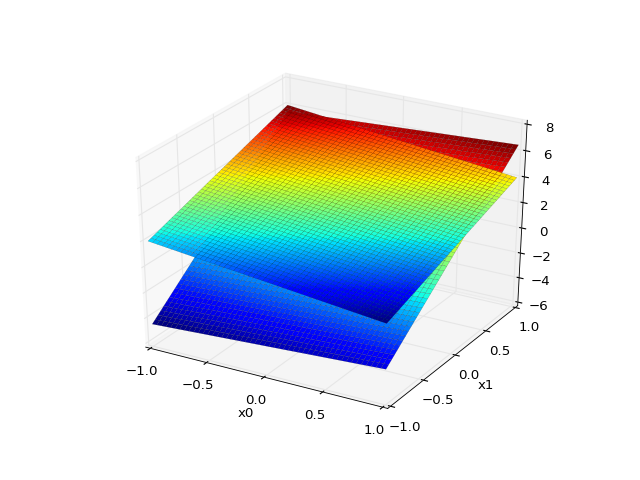

<IPython.core.display.Javascript object>


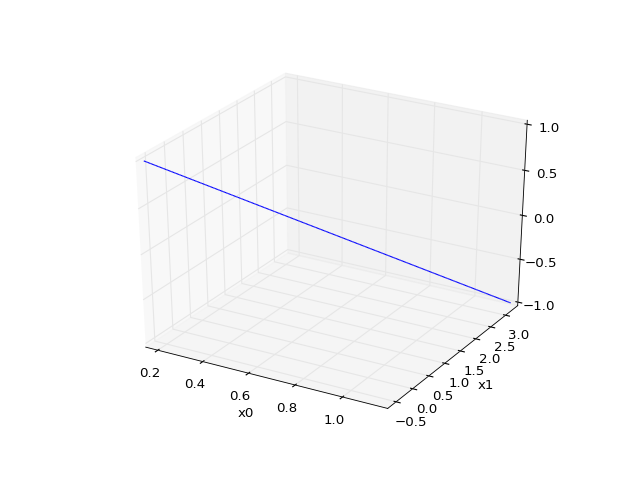

In [20]:
#test some intersection plotting
from sympy.plotting import plot, plot3d, plot3d_parametric_line

x0,x1,x2 = symbols('x0 x1 x2')
p0 = -1*x0 + 2*x1 + 3
p1 = 0.5*x0 + 5*x1 + 1
#p1_in_p0_x1 = p0.subs(x1, solve(p1, x1)[0])
p1_p0 = p0 - p1
p0_p1 = p1 - p0
p1_p0 = solve(p1_p0, x1)[0]
p0_p1 = solve(p0_p1, x0)[0]
p0_p1 = p0_p1.subs(x1, x0)
print(p1_p0)
#print(solve(p1, x0)[0])
f1 = plot3d(p0, (x0, -1,1), (x1, -1,1), xlabel="x0", ylabel="x1", show=False)
f2 = plot3d(p1, (x0, -1,1), (x1, -1,1), xlabel="x0", ylabel="x1", show=False)  # 3d parametric line plot
f1.extend(f2)
#f1.extend(f1_2)
f1.show()
f1_2 = plot3d_parametric_line(p1_p0, p0_p1, x0, (x0, -1, 1), show=False, xlabel="x0", ylabel="x1")
f1_2.show()